In [1]:
%matplotlib inline

# The code

## Introduction and basic structure

The main objective of this code is to implement the strategy presented in the previous sections to generate a library for SINDy. In order to do so the final output needs to be a list of callable functions.

In order to keep the code as tidy as possible the computation of the coefficients and that of the alpha matrix have been separated in two different modules. 

The main functionality of the codes are nothing more than a translation from matlab to python of the arbitrary Polynomial Chaos code (aPC) created by Oladyshkin {cite}`aPCMatlab`. The part that generates the list of functions has been, instead, written from scratch.

## The alpha Matrix

This first part of the code outputs the alpha matrix given the maximum degree of the expansion and the number of variables.

In [2]:
import numpy as np
from math import factorial

def MultivariatePolynomialIndex(
        N, # number of variables
        d  # degree of the polynomial expansion 
        ):
    M = int(factorial(N+d) / (factorial(N)*factorial(d))) # total number of inputs
    
    PossibleDegree = [list(range(d+1)) for i in range(N)]
    UniqueDegreeCombinations = np.array(np.meshgrid(*PossibleDegree))
    UniqueDegreeCombinations = UniqueDegreeCombinations.reshape((N,-1))
    UniqueDegreeCombinations = UniqueDegreeCombinations.T
    
    DegreeWeight = np.zeros(len(UniqueDegreeCombinations))
    for i in range(len(UniqueDegreeCombinations)):
        DegreeWeight[i] = sum(UniqueDegreeCombinations[i,:])
            
    ID = np.argsort(DegreeWeight)
    SortDegreeCombination = UniqueDegreeCombinations[ID,:]
    
    return SortDegreeCombination[0:M,:]

As an example the matrix for the 2-2 case, presented before, is calculated.

In [3]:
d = 2 # maximum degree of the expansion
N = 2 # number of variables

alpha = MultivariatePolynomialIndex(N,d)

print(alpha)

[[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]
 [0 2]]


It has to be noted that a diffierence in the construction of the `UniqueDegreeCombinations` matrix has as a result a sligthly different ordering of the indices with respect to the original code. However, it doesn't effect the role of the matrix in the final expansion.

## The coefficients and the Library

The main part of the code computes the coefficients of the expansion and output the list of functions to be transformed in a SINDy library.

The main class of the code deals with the calculation of the coefficients and uses the previous code to compute the alpha matrix. This informations are enough to fully characterize the expansion. The last function can take this data and output the desired function list.

A list of the functionalities of the class is summarised here to improve the readability:
* `ComputeMoments`: computes the necessary statistical moments given a set of data.
* `MomentMatrix`: generates the moment matrix to compute the coefficients of the PCE.
* `aPC_OneDimensional`: computes the coefficients of the PCE of the desired expansion degree. The option `threshold` allows to only retain coefficients that are above a specified magnitude (through the function `_sparsePolynomials`), while `normalize` computes the coefficients divided by the 2-norm of the polynomial (using `PolynomialNorm`).
* `ComputeCoefficients`: computes the tensor of coefficients up to the desired expansion degree for all the input data. 
* `printFeatureNames`: prints the calculated polynomials. The strings for each "feature" are generated using the `_get_feature_names` function. 

In [4]:
import numpy as np
import sympy as sym
from math import sqrt

class PolynomialChaos():
    '''
    Basic class for the Polynomial Chaos Expansion
    '''
    def __init__(self, 
                 distribution,
                 expansionDegree,
                 numberOfInputs):
        self.expansionDegree = expansionDegree
        self.distribution = distribution
        self.numberOfInputs = numberOfInputs
        
    def ComputeMoments(self, distribution_1D):
        '''
        Compute the statistical moments of a distribution (1D) up to the 
        2*expansionDegree (2*expansionDegree-1 would be sufficient, the last 
        could be useful for a furteher versions that implement normalization in 
        order to have orthonormal base)
        '''
        numberOfSamples = distribution_1D.shape[0]
        DistributionMoments = np.array([np.sum(distribution_1D**i)/numberOfSamples for i in range((self.expansionDegree+1)*2)])
        return DistributionMoments
        
    def MomentMatrix(self, distribution_1D, polynomialDegree):
        '''
        Generate the moment matrix to compute the coefficients for a polynomial 
        of degree polynomialDegree, as explained in the reference paper [1]
        '''
        d = polynomialDegree + 1
        Hankel = np.zeros((d,d)) # moments matrix initialization
        moments = self.ComputeMoments(distribution_1D)
        for i in range(polynomialDegree+1):
            for j in range(polynomialDegree+1):
                if i < polynomialDegree:
                    Hankel[i,j] = moments[i+j]
                else:
                    Hankel[i,-1] = 1
        return Hankel
    
    def aPC_OneDimensional(self, distribution_1D, threshold = 0.0, normalize = True):
        '''
        Computes and returns the coefficient matrix for a 1D distribution from the 0-degree
        polynomial up to the one of degree expansionDegree.
        '''
        d = self.expansionDegree + 1
        coefficients = np.zeros((d,d))
        coefficients[0,0] = 1
        for i in range(1,d):
            H = self.MomentMatrix(distribution_1D,i)
            v = np.zeros(i+1)
            v[-1] = 1
            coeff = np.linalg.solve(H,v)
            if not normalize: 
                coeff= self._sparsePolynomials(coeff, threshold)
                coefficients[0:i+1,i] = coeff
            else:
                norm = self.PolynomialNorm(coeff, distribution_1D)
                threshold = norm * threshold
                coeff= self._sparsePolynomials(coeff, threshold)
                coefficients[0:i+1,i] = coeff / sqrt(np.abs(norm)) # the abs is necessary since very small norms can be computed as negative
        # coefficients = np.reshape(coefficients,(d,d,1))
        return coefficients
    
    def _sparsePolynomials(self, coeff, threshold):
        '''
        Retain only those terms that are bigger then a threshold
        '''
        c = coeff
        big_ind = np.abs(c) >= threshold
        c[~big_ind] = 0
        return c
    
    def PolynomialNorm(self, coefficients, distribution_1D):
        '''
        Compute the l-2 norm of a polynomial given the distribution of the inputs 
        and the array of coefficients
        '''
        coeff = np.outer(coefficients, coefficients)
        moments = self.ComputeMoments(distribution_1D)
        for i in range(len(coefficients)):
            for j in range(len(coefficients)):
                coeff[i,j] = coeff[i,j] * moments[i+j]
        return np.sum(coeff)

    def ComputeCoefficients(self, threshold = 0.0, normalize = True):
        '''
        Computes the coefficient for the PC expansion (in general multidimensional).
        Makes use of the MultivariatePolynomialsIndex function to generate the 
        Alpha matrix useful for the construction of the base.
        The coefficient tensor and the Alpha matrix are enough to fully characterize
        the PC expansion
        
        The coefficient tensor has three dimensions, as:
            - the first represents the order of the sigle term (from 0 to expansionDegree)
            - the second the total degree of the polynomial (from 0 to expansionDegree)
            - the third the variable (from 1 to numberOfInputs)
        '''
        d = self.expansionDegree + 1
        
        if self.numberOfInputs == 1:
            self.coefficients = np.reshape(self.aPC_OneDimensional(self.distribution,
                                                                   threshold = threshold,
                                                                   normalize = normalize), (d,d,1))
            
            self.AlphaMatrix = np.array([range(d)]).T
        else:
            self.coefficients = np.zeros((d,d, self.numberOfInputs))
            for i in range(self.numberOfInputs):
                self.coefficients[:,:,i] = self.aPC_OneDimensional(self.distribution[:,i],
                                                                   threshold = threshold,
                                                                   normalize = normalize)
                

            self.AlphaMatrix = MultivariatePolynomialIndex(self.numberOfInputs, d-1)
            
    def _get_feature_names(self, namelist = None):
        N = self.AlphaMatrix.shape[1]
        
        if namelist == None: # generate default names
            namelist = [f'x{i}' for i in range(N)]
        self.feature_names = []    
        num = 0
        for row in self.AlphaMatrix:
            inds = np.where(row)[0]
            if len(inds):
                coeff = self.coefficients[:,row[inds], inds]
                # print('----- feature: ------')
                # print(coeff)
                name = f"f{num}: "
                for i in range(len(inds)):
                    varname = namelist[inds[i]]
                    exps = np.where(coeff[:,i])[0]
                    varcoeffs = coeff[exps,i]
                    name += '('
                    name += " + ".join('%0.3f%s^%d' % (coef, varname, exp)
                              if exp > 1
                              else '%0.3f%s' % (coef, varname) if exp == 1
                              else '%0.3f' % coef
                              for coef, exp in zip(varcoeffs, exps)
                              )
                    name += ')'
                    
            else:
                name = "f0: 1"
            self.feature_names.append(name)
            num += 1
        
        return self.feature_names
    
    def printFeatureNames(self, nameList = None):
        try:
            for name in self.feature_names:
                print(name)
        except:
            names = self._get_feature_names(nameList)
            for name in names:
                print(name)
            
     

The last function in the script generates the library in as a list of callable functions, so that it can be passed to the `pysindy.feature_library.custom_library` module. It acts by constructing the polynomials usign the passed coefficients as symbolic variables and multiplying them together, as defined by the alpha matrix.

In [5]:
   
            
def GenerateLibraryList(
        expansionDegree,
        coefficients,
        AlphaMatrix,
        intercept = True
        ):
    '''
    Given the Alpha matrix and the coefficient tensor conputes a list of functions
    ready to be transformed into a SINDy library.
    '''
    M , numberOfInputs = AlphaMatrix.shape # M = total number of terms in the expansion
    x = []
    for i in range(numberOfInputs): x.append(sym.symbols(f'x{i}')) # list of symbolic variables
    
    LibraryList = []
    if intercept:
        LibraryList.append(lambda *x: 1)
    
    for i in range(1, M): # order
        index = AlphaMatrix[i,:]
        MultivariatePolynomial = 1
        for j in range(numberOfInputs): # variable
            coeff = coefficients[:, index[j], j] 
            coeff = np.flip(coeff) # The MultivariatePolynomials function gives the coefficients from 0 to max_deg, while Poly starts from max_deg and goes to 0
            Polynomial1D = sym.Poly(coeff, x[j])
            MultivariatePolynomial = MultivariatePolynomial * Polynomial1D # multivaried polynomial object
            MultivariatePolynomial = MultivariatePolynomial.as_expr() 
            
        LibraryList.append(sym.lambdify(x, MultivariatePolynomial, 'numpy'))
        
    return LibraryList
        
     

As an example, the coefficients for the Legendre polynomials are calculated from an evely distributed $x$ over $\mathcal X \in [-1,1]$.

f0: 1
f1: (1.000x0)
f2: (-0.334 + 1.000x0^2)
f3: (-0.601x0 + 1.000x0^3)
f4: (0.086 + -0.859x0^2 + 1.000x0^4)
f5: (0.239x0 + -1.113x0^3 + 1.000x0^5)


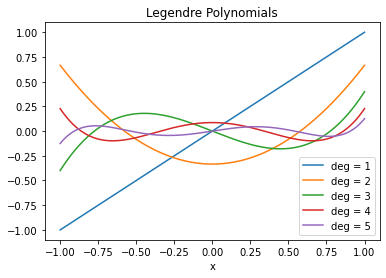

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm

n = 1000 # number of samples
data_uniform = np.linspace(-1,1,n)
data_uniform = np.array([data_uniform]) # to have the correct shape

expansionDegree = 5
numberOfInputs = 1

aPC = PolynomialChaos(data_uniform, expansionDegree, numberOfInputs)
aPC.ComputeCoefficients(threshold = 0.001, normalize=False)
coefficients = aPC.coefficients
A = aPC.AlphaMatrix
aPC.printFeatureNames()

LibraryList = GenerateLibraryList(5, coefficients, A)

fig, ax = plt.subplots()
for i in range(1,6):
    ax.plot(data_uniform[0], LibraryList[i](data_uniform).T, '-')
ax.legend(['deg = 1','deg = 2','deg = 3','deg = 4','deg = 5'])
ax.set_xlabel('x')
ax.set_title('Legendre Polynomials')
plt.show()


Note that the coefficient are the same as the classical ones up to a multiplicative constant, since the original Legendre polynomials are meant to be equal to $\pm1$ for $x=\pm1$

As a proof of concept a second variable following a gaussian distribution will be added. This one should generate Hermite Polynomials. The overall expansion will have 2 variables polynomials.

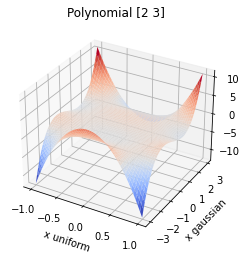

All terms in the expansion:
f0: 1
f1: (1.000x0)
f2: (1.000x1)
f3: (-0.334 + 1.000x0^2)
f4: (-0.978 + 0.016x1 + 1.000x1^2)
f5: (1.000x0)(1.000x1)
f6: (-0.018 + -2.799x1 + 0.040x1^2 + 1.000x1^3)
f7: (-0.334 + 1.000x0^2)(1.000x1)
f8: (1.000x0)(-0.978 + 0.016x1 + 1.000x1^2)
f9: (-0.601x0 + 1.000x0^3)
f10: (-0.601x0 + 1.000x0^3)(1.000x1)
f11: (2.265 + -0.388x1 + -5.112x1^2 + 0.159x1^3 + 1.000x1^4)
f12: (0.086 + -0.859x0^2 + 1.000x0^4)
f13: (-0.334 + 1.000x0^2)(-0.978 + 0.016x1 + 1.000x1^2)
f14: (1.000x0)(-0.018 + -2.799x1 + 0.040x1^2 + 1.000x1^3)
f15: (0.086 + -0.859x0^2 + 1.000x0^4)(1.000x1)
f16: (1.000x0)(2.265 + -0.388x1 + -5.112x1^2 + 0.159x1^3 + 1.000x1^4)
f17: (-0.601x0 + 1.000x0^3)(-0.978 + 0.016x1 + 1.000x1^2)
f18: (0.203 + 9.838x1 + -0.847x1^2 + -7.817x1^3 + 0.228x1^4 + 1.000x1^5)
f19: (0.239x0 + -1.113x0^3 + 1.000x0^5)
f20: (-0.334 + 1.000x0^2)(-0.018 + -2.799x1 + 0.040x1^2 + 1.000x1^3)


In [7]:
np.random.seed(43)
data_gaussian = np.random.randn(n)
x_min = np.min(data_gaussian)
data = np.zeros((n,2))
data[:,0] = data_uniform
data[:,1] = data_gaussian

numberOfInputs = 2

aPC = PolynomialChaos(data, expansionDegree, numberOfInputs)
aPC.ComputeCoefficients(threshold = 0.01, normalize = False)
coefficients = aPC.coefficients
A = aPC.AlphaMatrix

LibraryList = GenerateLibraryList(5, coefficients, A)

# FIGURES

x_min = np.min(data_gaussian)
x_max = np.max(data_gaussian)
X, Y = np.meshgrid(data_uniform, np.linspace(x_min,x_max,n)) 
Z = LibraryList[-1](X,Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,Z, cmap=cm.coolwarm)
ax.set_xlabel('x uniform')
ax.set_ylabel('x gaussian')
ax.set_title(f'Polynomial {A[-1]}')

plt.show()
print('All terms in the expansion:')
#print(A)
aPC.printFeatureNames()

This pyhton module is very general and make almost no assumptions about the data that it receives as input. Because of this it can be employed going forward regardless of the actual traning set that we want to use. The possbility to normalize and sparsify the results give more freedom to the user, allowing this code to be used in a wide range of applications. In the following sections it will be applied both to the discovery of the Wagner function and of the Theodorsen function. This will allow to show with real world data the advatages and pitfalls of this kind of basis funcitons.